In [177]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import geojson

In [2]:
s1_geo = geojson.load(open('../Results/S1.geojson','rb'))

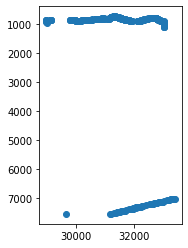

In [335]:
plt.gca().invert_yaxis()
plt.gca().set_aspect('equal', 'box')
coordinates = np.array(s1_geo["features"][0]["geometry"]["coordinates"][0])
plt.scatter(coordinates[:,0], coordinates[:,1])

In [249]:
hull = ConvexHull(coordinates)

Area: 26109265.372650005


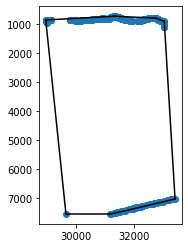

In [338]:
plt.gca().set_aspect('equal', 'box')
plt.gca().invert_yaxis()
plt.plot(coordinates[:,0], coordinates[:,1], 'o')
for simplex in hull.simplices:
    plt.plot(coordinates[simplex, 0], coordinates[simplex, 1], 'k-')
print('Area:', hull.volume)
plt.show()

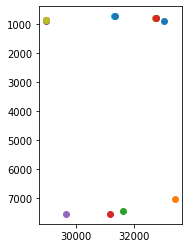

In [339]:
plt.gca().set_aspect('equal', 'box')
plt.gca().invert_yaxis()
hull_points = coordinates[hull.vertices]
for points in hull_points:
    plt.scatter(points[0], points[1])
plt.show()

In [140]:
# Cut by slice

In [190]:
import numpy as np
from numpy.linalg import det
from scipy.stats import dirichlet


def dist_in_hull(points, n):
    dims = points.shape[-1]
    hull = points[ConvexHull(points).vertices]
    deln = hull[Delaunay(hull).simplices]

    vols = np.abs(det(deln[:, :dims, :] - deln[:, dims:, :])) / np.math.factorial(dims)  
    print('vols: ', vols)
    sample = np.random.choice(len(vols), size = n, p = vols / vols.sum())

    return np.einsum('ijk, ij -> ik', deln[sample], dirichlet.rvs([1]*(dims + 1), size = n))


In [247]:
np.random.choice?

vols:  [6.05300428e+06 5.22332256e+06 1.64750000e+01 5.23776105e+06
 1.52809204e+06 8.88096000e+04 7.85920766e+06 5.18567950e+04
 5.95000000e-01 6.65257250e+04 6.61278700e+02 7.31395000e+00]


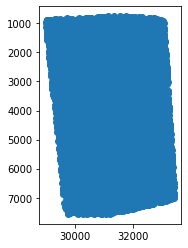

In [341]:
plt.gca().set_aspect('equal', 'box')
plt.gca().invert_yaxis()
points = dist_in_hull(coordinates, 10000)
plt.scatter(points[:,0], points[:,1])

In [343]:
nb_slices = 10

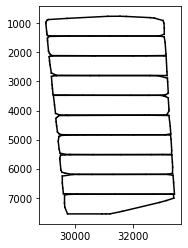

In [344]:
areas = []
last_y_treshold = points[:,1].min()
y_lenght = points[:,1].max() - points[:,1].min()
for i in range(nb_slices):
    treshold = last_y_treshold + (y_lenght / nb_slices)
    slice_points = points[np.where((points[:,1] >= last_y_treshold) & (points[:,1] < treshold))[0]]
    last_y_treshold = treshold
    slice_hull = ConvexHull(slice_points)
    for simplex in slice_hull.simplices:
        plt.plot(slice_points[simplex, 0], slice_points[simplex, 1], 'k-')
    areas.append(slice_hull.volume)
plt.gca().set_aspect('equal', 'box')
plt.gca().invert_yaxis()
plt.show()

In [246]:
sum(areas) 

26108225.006763045

In [ ]:
26109265.372650005

In [345]:
def cross(o, a, b):
    """ 2D cross product of OA and OB vectors,
     i.e. z-component of their 3D cross product.
    :param o: point O
    :param a: point A
    :param b: point B
    :return cross product of vectors OA and OB (OA x OB),
     positive if OAB makes a counter-clockwise turn,
     negative for clockwise turn, and zero
     if the points are colinear.
    """
 
    return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])

In [346]:
def in_hull(hull_vertices, points):
    inside = True
    for ind in range(1, len(hull_vertices)):
        res = cross(hull_vertices[ind-1], hull_vertices[ind], (points[0],points[1]))
        if res < 0:
            inside = False
    return inside

In [347]:
bbox = [hull.min_bound, hull.max_bound]

In [348]:
step = 10

In [349]:
grid = []
x = hull.min_bound[0]
while (x < hull.max_bound[0]):
    y = hull.min_bound[1]
    while(y < hull.max_bound[1]):
        if in_hull(coordinates[hull.vertices], np.array([x, y])):
            grid.append([x,y])
        y+=step
    x+=step

In [350]:
grid = np.array(grid)

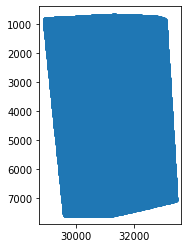

In [351]:
plt.gca().set_aspect('equal', 'box')
plt.gca().invert_yaxis()
plt.scatter(grid[:,0], grid[:,1])


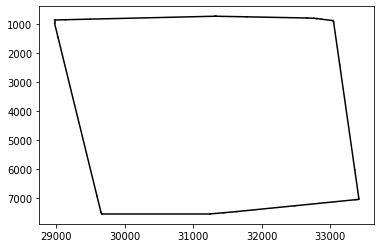

In [331]:
nb_slices = 1
areas = []
last_y_treshold = grid[:,1].min()
y_lenght = grid[:,1].max() - grid[:,1].min()
for i in range(nb_slices):
    treshold = last_y_treshold + (y_lenght / nb_slices)
    slice_points = grid[np.where((grid[:,1] >= last_y_treshold) & (grid[:,1] < treshold))[0]]
    last_y_treshold = treshold
    slice_hull = ConvexHull(slice_points)
    for simplex in slice_hull.simplices:
        plt.plot(slice_points[simplex, 0], slice_points[simplex, 1], 'k-')
    areas.append(slice_hull.volume)

plt.gca().invert_yaxis()
plt.show()

In [332]:
sum(areas)

26090200.0

In [322]:
 26109265.372650005

26109265.372650005

Area: 26109265.372650005


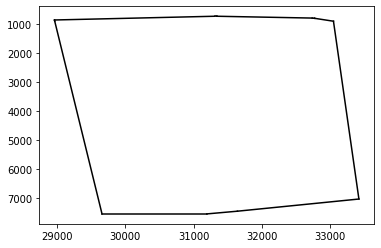

In [324]:
plt.gca().invert_yaxis()
for simplex in hull.simplices:
    plt.plot(coordinates[simplex, 0], coordinates[simplex, 1], 'k-')
print('Area:', hull.volume)
plt.show()

In [352]:
# Let's try with segment intersetion

In [353]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [386]:
def isBetween(segment_points, c):
    epsilon = 0.1
    a = segment_points[0]
    b = segment_points[1]
    crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])

    # compare versus epsilon for floating point values, or != 0 if using integers
    if abs(crossproduct) > epsilon:
        return False

    dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
    if dotproduct < 0:
        return False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    if dotproduct > squaredlengthba:
        return False

    return True


In [387]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y


In [401]:
def segment_intersection(seg1, seg2):
    try:
        coor = line_intersection(seg1, seg2)
        print(coor)
        if isBetween(seg1, coor) and isBetween(seg2, coord):
            return coor
        else:
            return None
    except:
        return None

In [402]:
line_1 = [[1.,1.],[2.,3.]]
line_2 = [[0.,-2.],[5.,-2.]]
segment_intersection(line_1, line_2)

(-0.5, -2.0)


In [403]:
pwd

'/home/jacquemi/working_dir/Rat_sscx_nissl/rat_sscx_nissl_analysis/notebook'